In [12]:
import seisbench
import seisbench.models as sbm

In [13]:
from obspy import read

In [14]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

In [15]:
X=read("X.sac")
Y=read("Y.sac")
Z=read("Z.sac")


In [16]:
stream = X+Y+Z

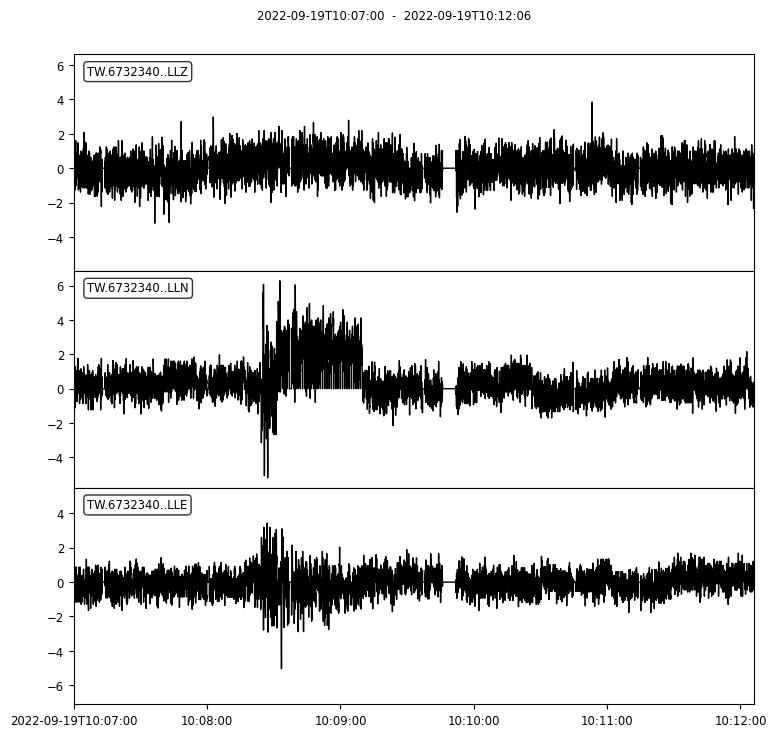

In [17]:
stream.plot(outfile="waveform.png")
stream.plot();

In [18]:

pn_model = sbm.PhaseNet.from_pretrained("stead")


# Various pre-trained weights for EQT
eqt_model = sbm.EQTransformer.from_pretrained("original")

# Various pre-trained weights for GPD
gpd_model = sbm.GPD.from_pretrained("stead")


In [19]:
pn_preds = pn_model.annotate(stream)
eqt_preds = eqt_model.annotate(stream)
gpd_preds = gpd_model.annotate(stream)

c:\Users\whes1015\AppData\Local\Programs\Python\Python310\lib\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (12.5). Applying a high-pass instead.
  warnings.warn(msg)


In [20]:
print(eqt_preds)

3 Trace(s) in Stream:
TW.6732340..EQTransformer_Detection | 2022-09-19T10:07:05.000000Z - 2022-09-19T10:12:01.030000Z | 100.0 Hz, 29604 samples
TW.6732340..EQTransformer_P         | 2022-09-19T10:07:05.000000Z - 2022-09-19T10:12:01.030000Z | 100.0 Hz, 29604 samples
TW.6732340..EQTransformer_S         | 2022-09-19T10:07:05.000000Z - 2022-09-19T10:12:01.030000Z | 100.0 Hz, 29604 samples


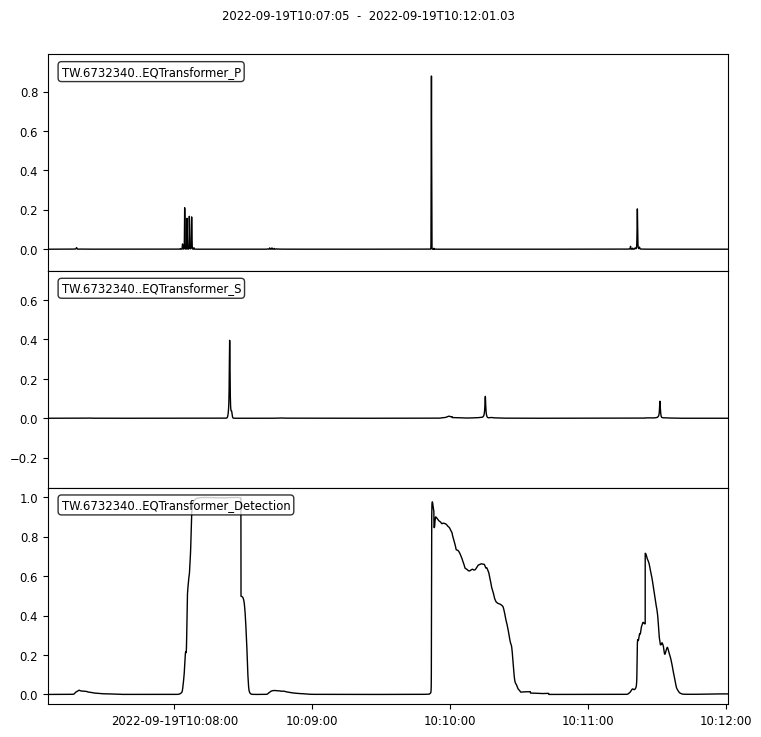

In [21]:
eqt_preds.plot(outfile="result.png")
eqt_preds.plot();

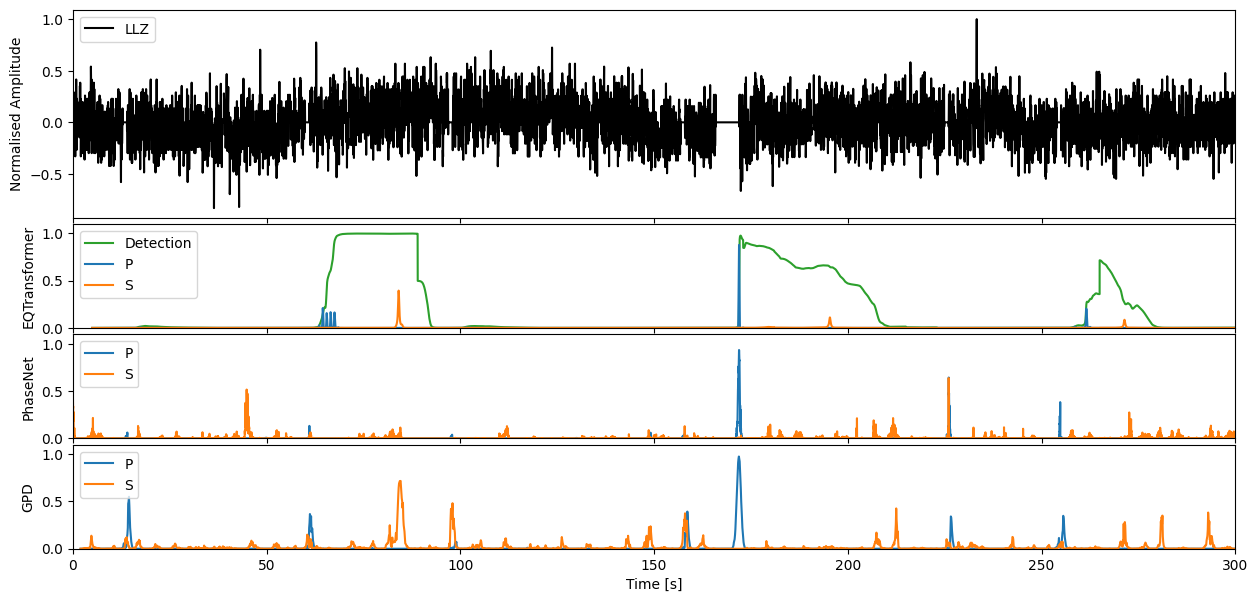

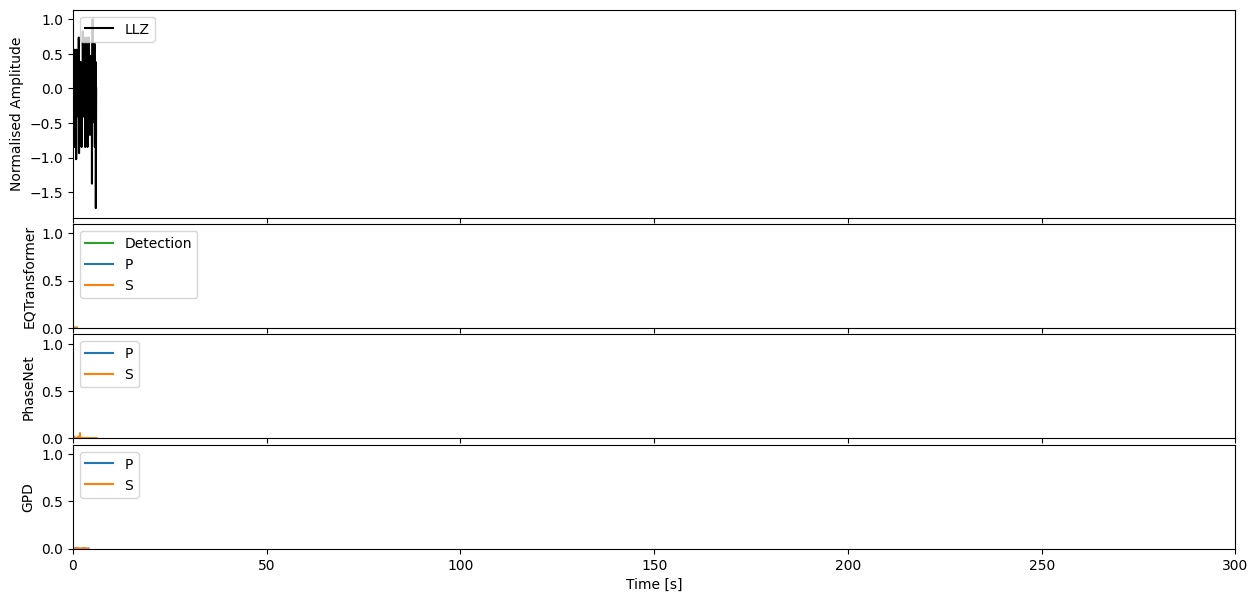

In [22]:
wlength = 5 * 60 

color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}

for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream.slice(t0, t1)

    fig, ax = plt.subplots(4, 1, figsize=(15, 7), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1, 1, 1]})
    
    for i, preds in enumerate([eqt_preds, pn_preds, gpd_preds]):
        subpreds = preds.slice(t0, t1)
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")
            if pred_class == "N":
                # Skip noise traces
                continue
            c = color_dict[pred_class]
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i + 1].set_ylabel(model)
        ax[i + 1].legend(loc=2)
        ax[i + 1].set_ylim(0, 1.1)
    
    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].set_ylabel('Normalised Amplitude')
    ax[3].set_xlabel('Time [s]')
    ax[0].legend(loc=2)
    plt.savefig("result2.png")